### M2 MVA - Computational Statistics
## TP 2 : Expectation-Maximisation algorithm– Importance sampling

**Student**: Lucas Versini

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

import scipy as sp
from scipy.special import logsumexp

### Exercise 1: Discrete distributions

**1.**  The cumulative distribution function of $X$ is given, for $t \in \mathbb{R}$, by
$F_X(t) = \mathbb{P}(X \leq t) = \sum\limits_{i = 1}^n p_i 1_{x_i \leq t} = \sum\limits_{i = 1}^n \left( \sum\limits_{k = 1}^i p_k \right) 1_{x_i \leq t < x_{i+1}}$.

Its generalized inverse is defined, for $u \in (0, 1)$, by
$F_X^{-1}(u) = \inf \{ t \in \mathbb{R} \mid F_X(t) \geq u \}$, and is then equal to
$\boxed{ F_X^{-1}(u) = \sum\limits_{i = 1}^n x_i 1_{u \in \left] \sum\limits_{k = 1}^{i - 1} p_k, \sum\limits_{k = 1}^i p_k \right]} }$.

To generate $X$, we generate $U \sim \mathcal{U}([0, 1])$, and set $X := F_X^{-1}(U)$.

**2.**

In [2]:
def generate_discrete(x, p, N = 1):
    """
    Draws N samples from the distribution of X given x and p.
    """
    cum_sum_p = np.cumsum(p)

    U = np.random.rand(N, 1)
    
    return x[np.argmax(cum_sum_p >= U, axis = 1)]  

**3.** We use `matplotlib.pyplot.bar` so that we can draw both the empirical distribution and the theoretical one.

In [3]:
def generate_discrete_and_plot(x, p, N):
    """
    Draws N samples from the distribution of X given x and p, and plots the histogram of the samples.
    """
    samples = generate_discrete(x, p, N)
    x, height = np.unique(samples, return_counts = True)
    
    plt.bar(x - 0.05, height / np.sum(height), width = 0.1, label = 'Empirical distribution')
    plt.bar(x + 0.05, p, width = 0.1, label = 'True distribution')
    plt.legend()
    plt.show()

We can try with a Bernoulli law with probability of success $0.7$ with $N = 10,000$:

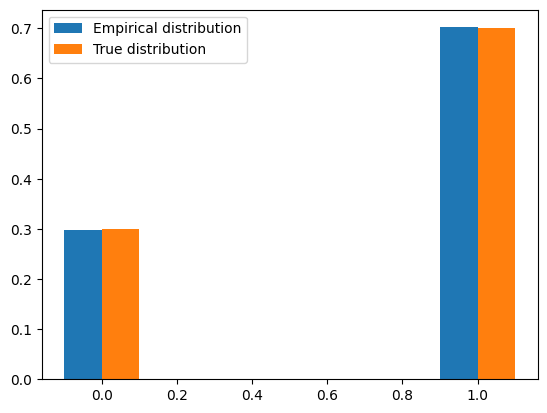

In [4]:
generate_discrete_and_plot(np.array([0., 1.]), np.array([0.3, 0.7]), 10000)

We can use a distribution on $\{ 1, 2, \dots, 10 \}$ with random probabilities and $N = 20,000$:

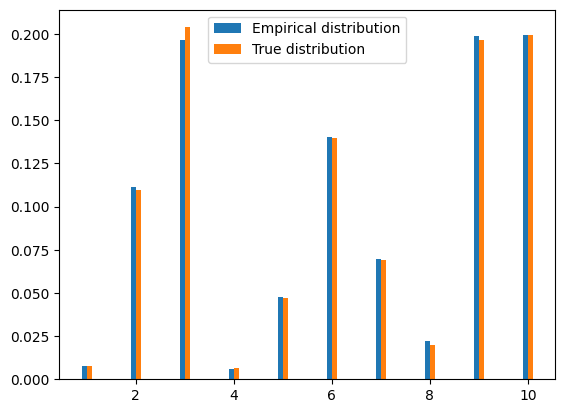

In [5]:
# Generate the probabilities
p = np.random.rand(10)
p /= np.sum(p)

# Generate and plot the samples
generate_discrete_and_plot(np.arange(1, 11), p, 20000)

The empirical and theoretical distributions are very close to each other for large values of $N$.

This is a consequence of the law of large numbers.

### Exercise 2: Gaussian mixture model and the EM algorithm

**1.**
The parameters are $\theta = \left( \alpha_1, \cdots, \alpha_m, \mu_1, \cdots, \mu_m, \Sigma_1, \cdots, \Sigma_m \right)$.

The likelihood is given by

\begin{align*}
    \mathcal{L}(x_1, \cdots, x_n; \theta)
    & = \prod\limits_{i = 1}^n f_\theta(x_i) \\
    & = \prod\limits_{i = 1}^n \sum_{j = 1}^m \mathbb{P}(Z_i = j) f_\theta(x_i \mid Z_i = j) \\
    & = \prod\limits_{i = 1}^n \sum_{j = 1}^m \alpha_j \phi_{\mu_j, \Sigma_j}(x_i),
\end{align*}

where $\phi_{\mu, \Sigma}$ is the density of $\mathcal{N}\left( \mu, \Sigma \right)$.

**2.** We generate the parameters of the gaussian mixture randomly (while making sure that the coefficients $\alpha_i$ are not too small, and the matrices $\Sigma_i$ are positive definite).

We also plot the samples and the p.d.f.

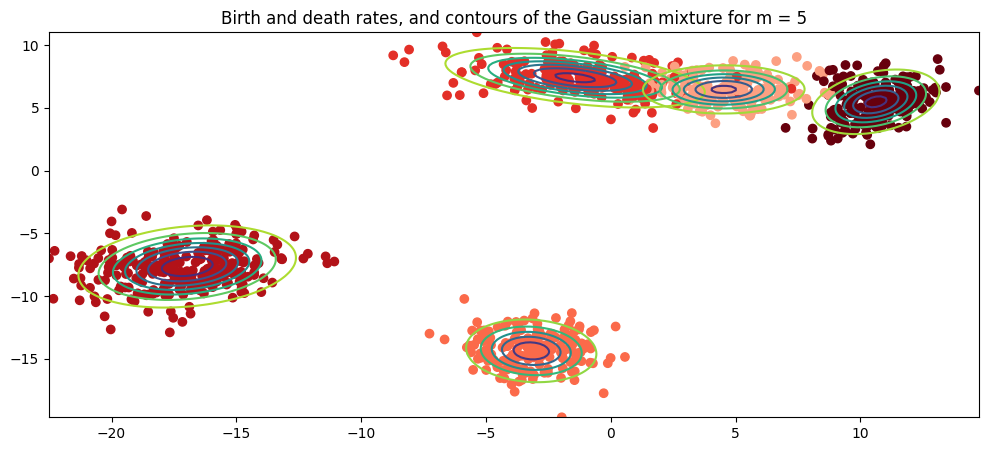

In [6]:
m = 5 # Number of clusters
n = 1000 # Number of samples
d = 2 # Dimension of the samples

def sample_gaussian_mixture(n, alpha, mu, sigma):
    """
    Generates samples from a Gaussian mixture distribution with parameters alpha, mu and sigma.

    Parameters: n (number of samples, int), alpha (weights of the clusters, array of shape (m,)),
                mu (means of the clusters, array of shape (m, d)), sigma (covariance matrices of the clusters, array of shape (m, d, d))
    Returns: X (samples, array of shape (n, d)), Z (cluster assignments, array of shape (n,))
    """
    m = len(alpha)
    Z = generate_discrete(np.arange(m), alpha, n)
    X = np.array([np.random.multivariate_normal(mu[Z[i]], sigma[Z[i]]) for i in range(n)])

    return X, Z

def plot_contour(data, cluster, mu, sigma, m, xmin = None, xmax = None, ymin = None, ymax = None):
    """
    Plots the data and the contours of the Gaussian mixture with parameters mu and sigma.

    Parameters: data (samples, array of shape (n, d)), cluster (cluster assignments, array of shape (n,)),
                mu (means of the clusters, array of shape (m, d)), sigma (covariance matrices of the clusters, array of shape (m, d, d)),
                m (number of clusters, int), xmin, xmax, ymin, ymax (plot limits, float)
    """
    xmin = np.min(data[:, 0]) if xmin is None else xmin
    xmax = np.max(data[:, 0]) if xmax is None else xmax
    ymin = np.min(data[:, 1]) if ymin is None else ymin
    ymax = np.max(data[:, 1]) if ymax is None else ymax
    
    plt.figure(figsize = (12, 5))
    x, y = np.linspace(xmin, xmax, 200), np.linspace(ymin, ymax, 200)
    X_, Y_ = np.meshgrid(x, y)
    
    if data is not None and cluster is not None:
        cmap = plt.get_cmap('Reds_r', np.max(cluster) + 3)
        colors = [cmap(label) for label in cluster]
        plt.scatter(data[:, 0], data[:, 1], marker = 'o', c = colors)
    
    for j in range(m): 
        Z = - sp.stats.multivariate_normal.pdf(np.array([X_.ravel(), Y_.ravel()]).T, mu[j], sigma[j])
        Z = Z.reshape(X_.shape)
        plt.contour(X_, Y_, Z)
    
    plt.xlim(xmin, xmax)
    plt.ylim(ymin, ymax)
    plt.title(f'Birth and death rates, and contours of the Gaussian mixture for m = {m}')
    plt.show()

# Generate random parameters alpha, mu and sigma
true_alpha = np.random.rand(m) + 0.5 # To ensure that each cluster has at least some samples
true_alpha /= np.sum(true_alpha)

true_mu = 10 * np.random.randn(m, d)

true_sigma = np.random.randn(m, d, d)
true_sigma = np.einsum('ijk,ilk->ijl', true_sigma, true_sigma) + np.eye(d) # To make sigma positive definite

X, Z = sample_gaussian_mixture(n, true_alpha, true_mu, true_sigma)
# draw_confidence_region(true_mu, true_sigma, X, Z)
plot_contour(X, Z, true_mu, true_sigma, m)

**3.**

For the Gaussian mixture model, the EM algorithm reads:

**E-step**:
$$Q(\theta, \theta^t)
= \sum\limits_{i = 1}^n \sum\limits_{j = 1}^m \underbrace{\dfrac{\alpha_j^{(t)} \phi (X_i; \mu_j^{(t)}, \Sigma_j^{(t)})}{\sum\limits_{k = 1}^m \alpha_k^{(t)} \phi (X_i; \mu_k^{(t)}, \Sigma_k^{(t)})}}_{:= \beta_{i,j}^{(t)}} \left( \log \alpha_j -\frac12 \log\det \Sigma_j - \frac12 (X_i - \mu_j)^T \Sigma_j^{-1} (X_i - \mu_j) \right) + \underbrace{C}_{\text{constant}}$$

**M-step**:

$$
\boxed{
    \mu_j^{(t+1)} = \dfrac{\sum\limits_{i = 1}^n \beta_{i, j}^{(t)} X_i}{\sum\limits_{i = 1}^n \beta_{i, j}^{(t)}}, \quad
    \Sigma_{j}^{(t+1)} = \dfrac{\sum\limits_{i = 1}^n \beta_{i, j}^{(t)} (X_i - \mu_j^{(t+1)})(X_i - \mu_j^{(t+1)})^T}{\sum\limits_{i = 1}^n \beta_{i, j}^{(t)}}, \quad
    \alpha_j^{(t+1)} = \dfrac1n \sum\limits_{i = 1}^n \beta_{i, j}^{(t)}
}
$$
where $\beta_{i, j}^{(t)} = \dfrac{\alpha_j^{(t)} \phi (X_i; \mu_j^{(t)}, \Sigma_j^{(t)})}{\sum\limits_{k = 1}^m \alpha_k^{(t)} \phi (X_i; \mu_k^{(t)}, \Sigma_k^{(t)})}$.

We write a function `EM_algorithm(samples, m, n_iter = 100)` which performs the EM algorithm, and returns the estimated parameters, as well as the evolution of the log-likelihood. Note that we fully use `numpy`, and avoid `for` loops (except some that cannot be avoided, such as the iteration loop).

To compute the log-likelihood, we simply use
$$
    \log \mathcal{L}(x_1, \dots, x_n; \theta)
    = \sum\limits_{i = 1}^n \log\left( \sum_{j = 1}^m \alpha_j \phi_{\mu_j, \Sigma_j}(x_i) \right),
$$
and since $\phi$ contains an exponential, we actually first compute $\log\left( \alpha_j \phi_{\mu_j, \Sigma_j}(x_i) \right)$, and then
$\log\left( \sum\limits_{j = 1}^m \alpha_j \phi_{\mu_j, \Sigma_j}(x_i) \right)
= \log\left( \sum\limits_{j = 1}^m \exp\left( \log\left( \alpha_j \phi_{\mu_j, \Sigma_j}(x_i) \right) \right) \right)$, which is more stable numerically (using the function `logsumexp` from `scipy`).

In [7]:
def EM_algorithm(samples, m, n_iter = 100):
    """
    Estimates the parameters of the mixture of Gaussians model using the EM algorithm.

    Parameters:
    samples (array of shape (n, d)), m (int), n_iter (int)

    Returns:
    alpha: the estimated mixing coefficients, array of shape (m,)
    mu: the estimated means, array of shape (m, d)
    sigma: the estimated covariance matrices, array of shape (m, d, d)
    """

    n, d = samples.shape

    # Initialization of the parameters
    alpha = np.ones(m) / m
    mu = samples.mean(axis = 0) + np.random.randn(m, d)
    sigma = np.std(samples) * np.array([np.eye(d) for _ in range(m)])
    sigma_inv = np.linalg.inv(sigma)

    # Lists to store the log-likelihood
    list_log_likelihood = []

    # Auxiliary variable to store the quadratic form
    aux = samples[:, None, :] - mu[None, :, :] # Shape (n, m, d). (i, j, _): samples[i] - mu[j]
    aux = np.einsum('ijk,jkl,ijl->ij', aux, sigma_inv, aux) # Shape (n, m). (i, j, _): (samples[i] - mu[j])^T sigma_inv[j] (samples[i] - mu[j])

    for _ in range(n_iter):
        # E-step
        beta = np.log(alpha) - 0.5 * aux - 0.5 * np.linalg.slogdet(sigma)[1] - d / 2 * np.log(2 * np.pi) # Shape (n, m)
        beta = np.exp(beta - logsumexp(beta, axis = 1, keepdims = True))

        # M-step
        alpha = np.sum(beta, axis = 0) / n

        mu = beta.T @ samples / np.sum(beta, axis = 0).reshape(-1, 1)

        samples_means = samples[:, None, :] - mu[None, :, :] # Shape (n, m, d). (i, j, _): samples[i] - mu[j]
        intermediary = np.einsum('ijk,ijl->ijkl', samples_means, samples_means) # Shape (n, m, d, d). (i, j, _): (samples[i] - mu[j]) (samples[i] - mu[j])^T
        sigma = np.sum(np.einsum('ij,ijkl->ijkl', beta, intermediary), axis = 0) / np.sum(beta, axis = 0).reshape(-1, 1, 1)
        sigma_inv = np.linalg.inv(sigma)

        aux = samples[:, None, :] - mu[None, :, :] # Shape (n, m, d). (i, j, _): samples[i] - mu[j]
        aux = np.einsum('ijk,jkl,ijl->ij', aux, sigma_inv, aux) # Shape (n, m). (i, j, _): (samples[i] - mu[j])^T sigma_inv[j] (samples[i] - mu[j])
        
        # Compute the log-likelihood
        likelihood = logsumexp(np.log(alpha) - 0.5 * aux - 0.5 * np.linalg.slogdet(sigma)[1] - d / 2 * np.log(2 * np.pi), axis = 1).sum()
        list_log_likelihood.append(likelihood)

    return alpha, mu, sigma, list_log_likelihood

We use $100$ iterations, which is enough here.

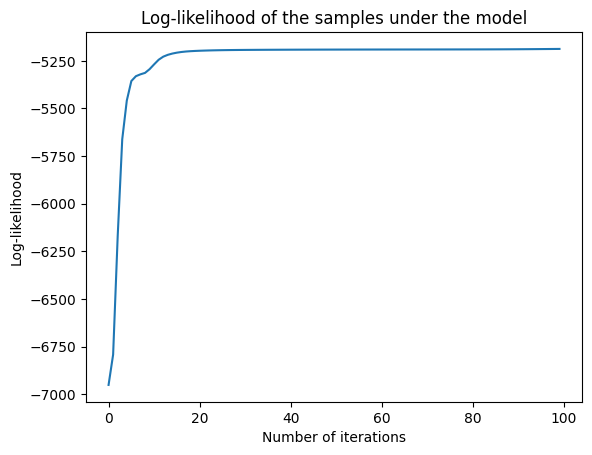

In [8]:
m = 5
alpha_hat, mu_hat, sigma_hat, list_log_likelihood = EM_algorithm(X, m, 100)

plt.plot(list_log_likelihood)
plt.xlabel('Number of iterations')
plt.ylabel('Log-likelihood')
plt.title('Log-likelihood of the samples under the model')
plt.show()

We see that the log-likelihood often stabilizes after less than $20$ iterations.

**4.** Below we plot the samples and the confidence regions based on the estimated parameters.

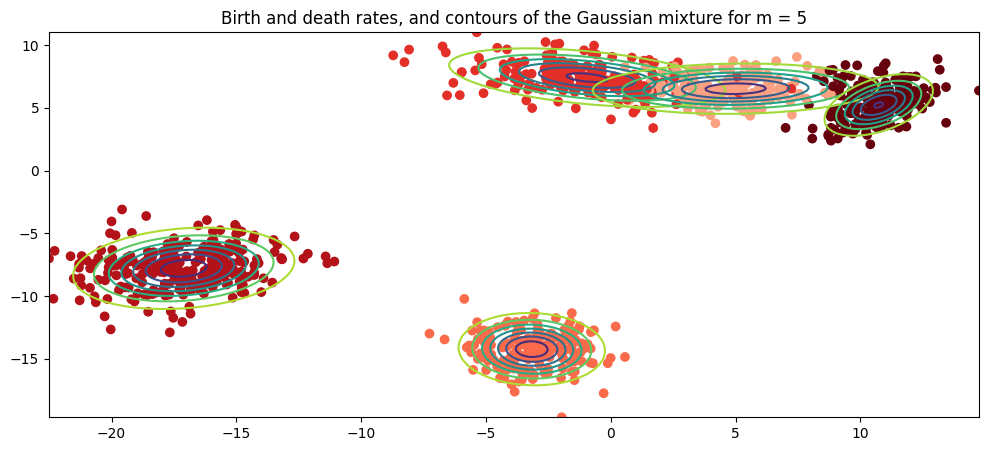

In [9]:
plot_contour(X, Z, mu_hat, sigma_hat, m)

We see that the estimated parameters seem very accurate (at least for $\mu, \Sigma$).

As for $\alpha$, one can simply print these parameters (however note that the clusters do not necessarily have the same order of appearance in the true parameters and the estimated ones):

In [10]:
print(f"True alpha: {true_alpha}")
print(f"Estimated alpha: {alpha_hat}")

True alpha: [0.22719253 0.25287048 0.20427502 0.15420321 0.16145877]
Estimated alpha: [0.18024831 0.21580808 0.16999998 0.17994361 0.25400002]


So the estimated parameters are indeed good estimations of the real ones.

**5.**

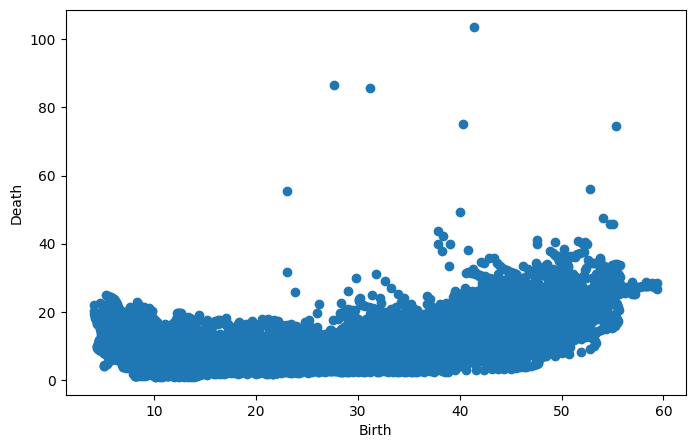

In [11]:
data = pd.read_csv('WPP2022_Demographic_Indicators_Medium.csv', dtype = 'str')[['CBR','CDR']].dropna()
data = np.array(data, dtype = 'float64')

plt.figure(figsize = (8, 5))
plt.scatter(data[:, 0], data[:, 1])
plt.ylabel('Death')
plt.xlabel('Birth')
plt.show()

Using a mixture of Gaussian distributions seems to be a good idea: it looks like in order to explain the data, we could distingush at least three different areas (for a small birth rate, the death rate decreases with the birth rate; for an intermediate birth rate, the death rate does not increase nor decrease; for a large birth rate, the death rate increases).

Moreover, this data was obtained by combining data from different countries; many factors vary from one country to another, so using several Gaussian distributions combined seems promising.

**6.**

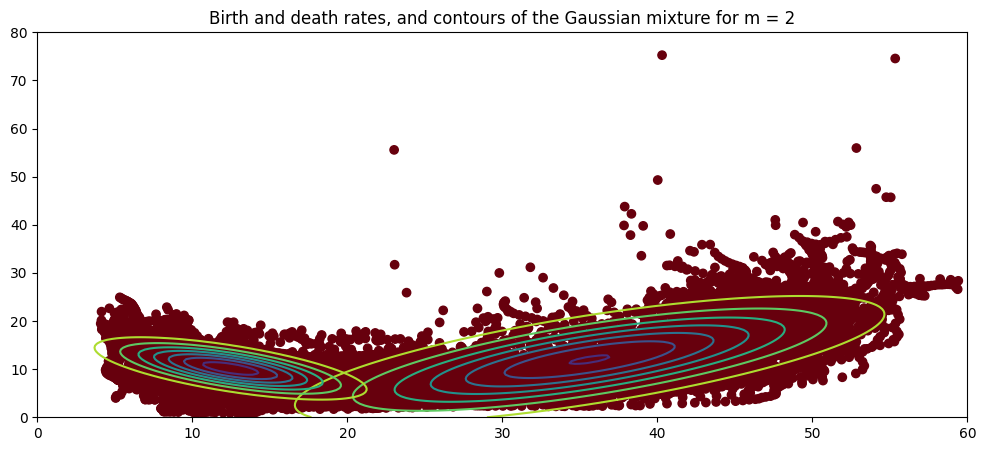

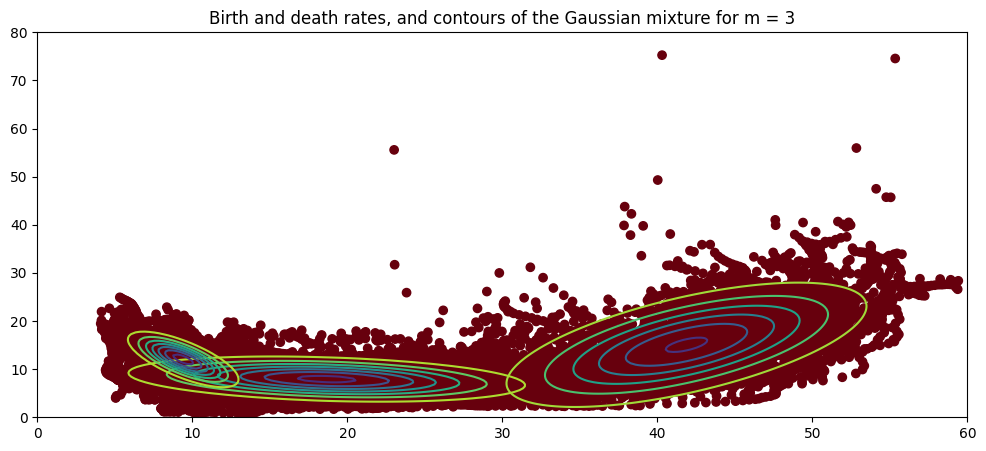

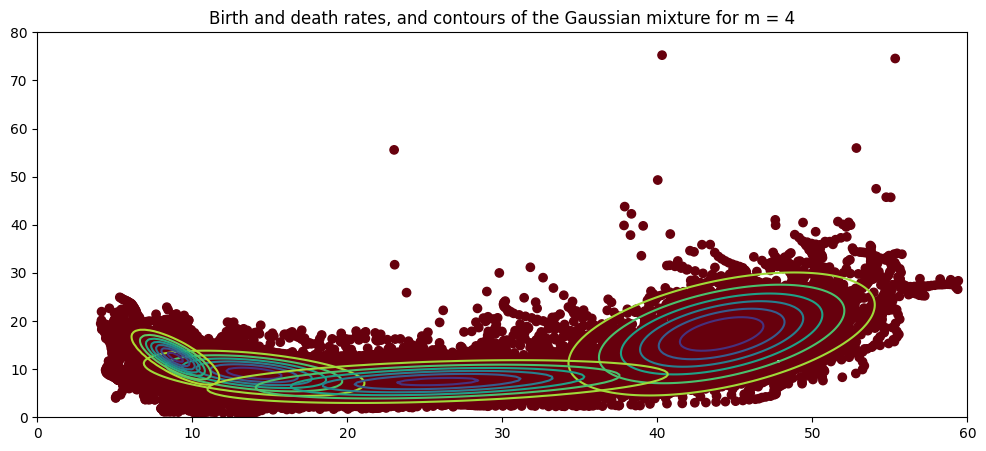

In [12]:
for m in [2, 3, 4]: 
    alpha, mu, sigma, loglikelihood = EM_algorithm(data, m)
    
    plot_contour(data, [0] * len(data), mu, sigma, m, xmin = 0, xmax = 60, ymin = 0, ymax = 80)

For $m = 3$, we observe what we were expecting (low birth rate and decreasing death rate; intermediate birth rate and constant death rate; high birth rate and increasing death rate).

We now count the number of degrees of freedom of the mixture model with $m$ clusters.

- For the $\alpha_i$'s, there are $m$ parameters, and one constraint $\sum\limits_{i = 1}^m \alpha_i = 1$, hence $m - 1$ degrees of freedom;

- For the $\mu_i$'s, there are $md$ degrees of freedom;

- For the $\Sigma_i$'s that are symmetric, there are $m \times \dfrac{d(d+1)}{2}$ degrees of freedom.

Hence a total of $\dfrac{md(d+3)}{2} + m - 1$ degrees of freedom.

Computing BIC for m = 1. BIC: 298445.
Computing BIC for m = 2. BIC: 269989.
Computing BIC for m = 3. BIC: 261817.
Computing BIC for m = 4. BIC: 259464.
Computing BIC for m = 5. BIC: 258886.
Computing BIC for m = 6. BIC: 258207.
Computing BIC for m = 7. BIC: 258027.
Computing BIC for m = 8. BIC: 257778.
Computing BIC for m = 9. BIC: 257685.
Computing BIC for m = 10. BIC: 257422.


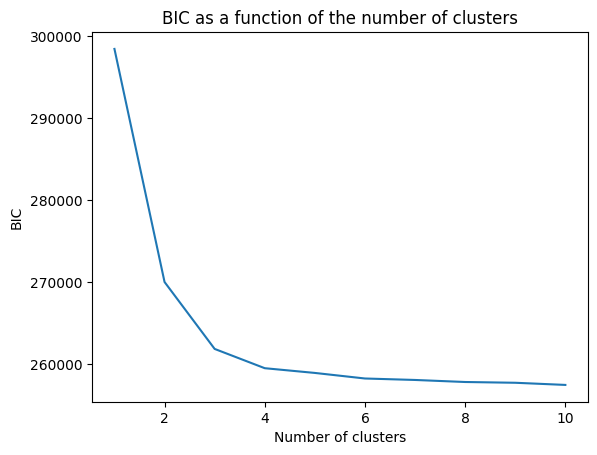

In [13]:
def df(m, d = 2):
    return m * d * (d + 3) / 2 + m - 1

def BIC(X, m, n_iter = 100):
    _, _, _, list_log_likelihood = EM_algorithm(X, m, n_iter)
    n, _ = X.shape
    return -list_log_likelihood[-1] + df(m) * np.log(n) / 2

m_lim = 10

bic_list = []

for m in range(1, m_lim + 1):
    print(f"Computing BIC for m = {m}.", end = '')
    bic_list.append(BIC(data, m))
    print(f" BIC: {bic_list[-1]:.0f}.")

plt.plot(range(1, m_lim + 1), bic_list)
plt.xlabel('Number of clusters')
plt.ylabel('BIC')
plt.title('BIC as a function of the number of clusters')
plt.show()

The BIC typically decreases when the number of clusters $m$ increases: the panelty on the number of degrees of freedom apparently does not entirely prevent overfitting (because this is what happens: clearly graphically, values of $m = 10$ are not really interpretable).

However, it does not decrease much after $m = 3$.

### Exercise 3: Importance sampling

#### 3.A - Poor Importance Sampling

**1.** We sample from $X \sim q$, so we can have $X < 0$. There are two options:

- Consider that $X$ can be negative, in which case $\frac{g(X)p(X)}{q(X)} = 0$.

- Sample not from $q$ itself, but from the density of $Y$, where the law of $Y$ is the law of $X$ conditionally to $X \geq 0$.
The two densities will be equal up to a multiplicative constant on $\mathbb{R}_+$, and since $q$ is already a density up to a multiplicative constant, this does not change much.

So we sample $Y \sim \mathcal{L}(X \mid X > 0)$.

In [14]:
def f(x):
    return 2 * (x >= 0) * np.sin(np.pi / 1.5 * x)

def p(x):
    x = x * (x >= 0)
    return x**(1.65 - 1) * np.exp(-x**2 / 2)

def q(x, mu = 0.8):
    return 2. / np.sqrt(2 * np.pi * 1.5) * np.exp(-(x - mu)**2 / (2 * 1.5))

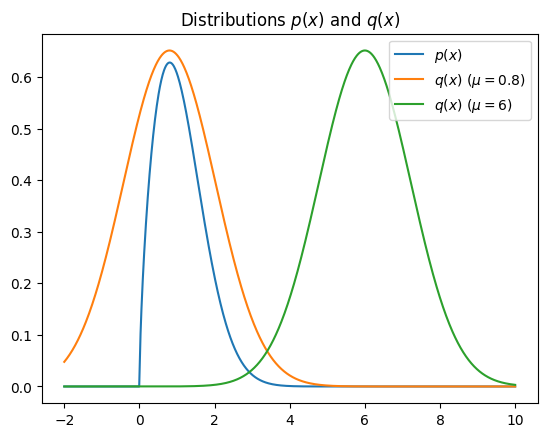

In [15]:
x = np.linspace(-2, 10, 1000)
plt.plot(x, p(x), label = r"$p(x)$")
plt.plot(x, q(x, 0.8), label = r"$q(x)$ ($\mu = 0.8$)")
plt.plot(x, q(x, 6.), label = r"$q(x)$ ($\mu = 6$)")
plt.legend()
plt.title(r"Distributions $p(x)$ and $q(x)$")
plt.show()

In [16]:
def sample_q(mu = 0.8, sigma2 = 1.5, N = 1):
    """ Draws N samples from the distribution q conditioned on x >= 0. """
    x = []
    while len(x) < N:
        x_ = np.random.normal(mu, sigma2)
        if x_ >= 0:
            x.append(x_)
    return np.array(x)
    # If having exactly N samples is not important, we can use the following:
    # x = np.random.normal(mu, sigma2, N)
    # return x[x >= 0]

def importance_sampling(mu = 0.8, sigma2 = 1.5, N = 1):
    """
    Computes the expectation of f(X) under the distribution p using importance sampling.
    Returns: expectation (float), variance (float), weights (array of shape (N,))
    """
    x = sample_q(mu, sigma2, N)
    x = np.sort(x) # To have a better visualization of the weights

    w = p(x) / q(x, mu)
    normalized_w = w / np.mean(w)

    mean = np.mean(f(x) * normalized_w)
    variance = np.mean((f(x) - mean)**2 * normalized_w)

    return mean, variance, normalized_w

**2.** For each value of $N$, we run $100$ simulations to estimate the quantity of interest, and we then display the mean and variance of the obtained results.

In [17]:
n_runs = 200
list_N = [10, 100, 1000, 10000]

res = np.zeros((n_runs, len(list_N)))

mu = 0.8

for j, N in enumerate(list_N):
    for i in range(n_runs):
        res[i, j] = importance_sampling(N = N, mu = mu)[0]
    print(f"Mean of the importance sampling estimator for mu = {mu}, N = {N}: {np.mean(res[:, j]):.4f} (variance: {np.var(res[:, j]):.4f}).")

Mean of the importance sampling estimator for mu = 0.8, N = 10: 0.6707 (variance: 0.1550).
Mean of the importance sampling estimator for mu = 0.8, N = 100: 0.6741 (variance: 0.0198).
Mean of the importance sampling estimator for mu = 0.8, N = 1000: 0.6822 (variance: 0.0014).
Mean of the importance sampling estimator for mu = 0.8, N = 10000: 0.6829 (variance: 0.0002).


The value obtained for $N = 10,000$ is between $0.68$ and $0.69$. We see that the larger $N$ is, the smaller the variance of the estimator is.

We can also look at the weights:

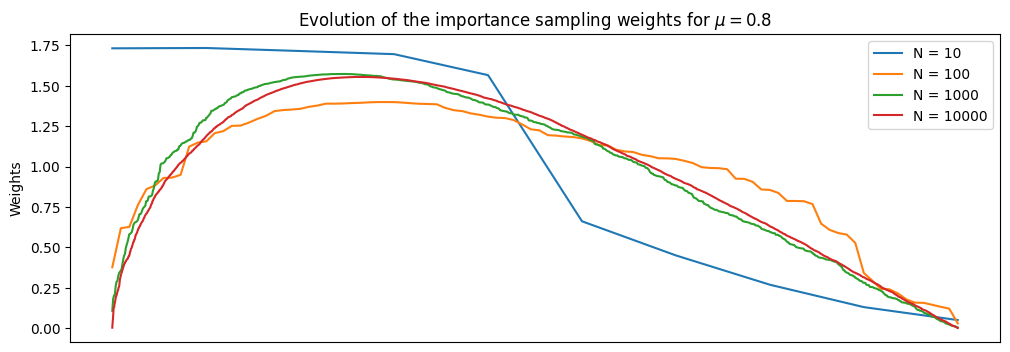

In [18]:
plt.figure(figsize = (12, 4))

mu = 0.8

for N in [10, 100, 1000, 10000]:
    _, _, w = importance_sampling(N = N, mu = mu)
    plt.plot(np.linspace(0, 5, len(w)), w, label = 'N = {}'.format(N))

plt.legend()
plt.ylabel('Weights')
plt.title(r"Evolution of the importance sampling weights for $\mu = {}$".format(mu))
plt.xticks([])
plt.show()

**3.**

In [19]:
n_runs = 200
list_N = [10, 100, 1000, 10000]

res = np.zeros((n_runs, len(list_N)))

mu = 6

for j, N in enumerate(list_N):
    for i in range(n_runs):
        res[i, j] = importance_sampling(N = N, mu = mu)[0]
    print(f"Mean of the importance sampling estimator for mu = {mu}, N = {N}: {np.mean(res[:, j]):.4f} (variance: {np.var(res[:, j]):.4f}).")

Mean of the importance sampling estimator for mu = 6, N = 10: 0.4128 (variance: 1.8423).
Mean of the importance sampling estimator for mu = 6, N = 100: -0.7494 (variance: 1.2329).
Mean of the importance sampling estimator for mu = 6, N = 1000: 0.2095 (variance: 1.2923).
Mean of the importance sampling estimator for mu = 6, N = 10000: 1.1631 (variance: 0.0552).


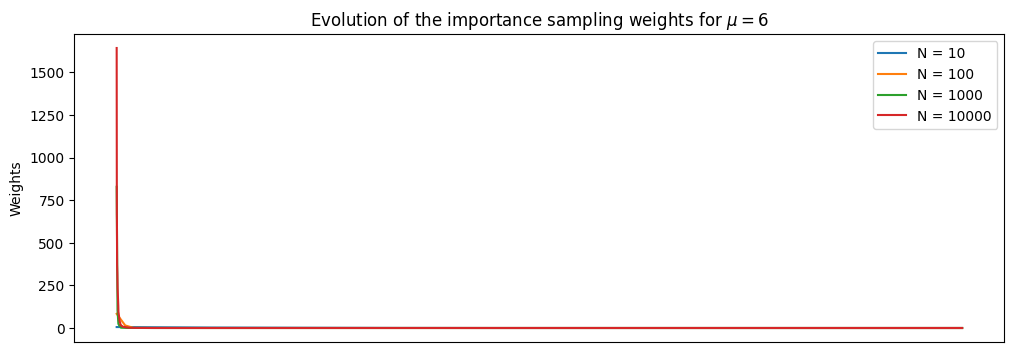

In [20]:
plt.figure(figsize = (12, 4))

mu = 6

for N in [10, 100, 1000, 10000]:
    _, _, w = importance_sampling(N = N, mu = mu)
    plt.plot(np.linspace(0, 5, len(w)), w, label = 'N = {}'.format(N))

plt.legend()
plt.ylabel('Weights')
plt.title(r"Evolution of the importance sampling weights for $\mu = {}$".format(mu))
plt.xticks([])
plt.show()

For $\mu = 6$, the weights are this time much less relevant than before: they are almost all equal to $0$.

This is because $p$ and $q$ almost do not overlap, so for each value of $x$ drawn according to $q$, we tend to have $p(x)$ small, so $\dfrac{p(x)}{q(x)}$ is close to $0$.

### 3.B– Adaptative Importance Sampling

**4.**
We want to maximize
$$
\sum\limits_{i = 1}^n \tilde{\omega}_i^{(0)} \log\left( \sum\limits_{j = 1}^M \alpha_j \varphi(X_i^{(0)}; \theta_j) \right).
$$

We define the coefficients $\beta_{i, j}$ as in Exercise 2. (question 3.). Since these coefficients are positive, and sum up to one, by Jensen inequality we have:
\begin{align*}
    \sum\limits_{i = 1}^n \tilde{\omega}_i^{(0)} \log\left( \sum\limits_{j = 1}^M \alpha_j \varphi(X_i^{(0)}; \theta_j) \right)
    & = \sum\limits_{i = 1}^n \tilde{\omega}_i^{(0)} \log\left( \sum\limits_{j = 1}^M \frac{\alpha_j \varphi(X_i^{(0)}; \theta_j)}{\beta_{i, j}^{(t)}} \beta_{i, j}^{(t)} \right) \\
    & \geq \sum\limits_{i = 1}^n \tilde{\omega}_i^{(0)} \sum\limits_{j = 1}^M \log\left(  \frac{\alpha_j \varphi(X_i^{(0)}; \theta_j)}{\beta_{i, j}^{(t)}} \right) \beta_{i, j}^{(t)} \\
    & = \sum\limits_{i = 1}^n \sum\limits_{j = 1}^M \tilde{\omega}_i^{(0)} \beta_{i, j}^{(t)} \log\left(  \alpha_j \varphi(X_i^{(0)}; \theta_j) \right) + \text{constant independent of $\theta$}\\
\end{align*}

We see that we obtained the same expression as $Q(\theta, \theta^t)$ as in Exercise 2., but by replacing $\beta_{i, j}^{(t)}$ with $\tilde{\omega}_i^{(0)} \beta_{i, j}^{(t)}$.

Therefore we can use the same updates as in Exercise 2., replacing $\beta_{i, j}^{(t)}$ with $\tilde{\omega}_i^{(0)} \beta_{i, j}^{(t)}$ (and we need to be careful with the update of the $\alpha$ coefficients: forming the Lagrangian, differentiating, we see that instead of the factor $\frac1n$, we get something depending on the $\omega$ coefficients):

$$
\boxed{
    \mu_j^{(t+1)} = \dfrac{\sum\limits_{i = 1}^n \tilde{\omega}_i^{(0)} \beta_{i, j}^{(t)} X_i}{\sum\limits_{i = 1}^n \tilde{\omega}_i^{(0)} \beta_{i, j}^{(t)}}, \quad
    \Sigma_{j}^{(t+1)} = \dfrac{\sum\limits_{i = 1}^n \tilde{\omega}_i^{(0)} \beta_{i, j}^{(t)} (X_i - \mu_j^{(t+1)})(X_i - \mu_j^{(t+1)})^T}{\sum\limits_{i = 1}^n \tilde{\omega}_i^{(0)} \beta_{i, j}^{(t)}}, \quad
    \alpha_j^{(t+1)} = \frac{\sum\limits_{i = 1}^n \tilde{\omega}_i^{(0)} \beta_{i, j}^{(t)}}{\sum\limits_{i = 1}^n \tilde{\omega}_i^{(0)}}
}
$$
where $\beta_{i, j}^{(t)} = \dfrac{\alpha_j^{(t)} \phi (X_i; \mu_j^{(t)}, \Sigma_j^{(t)})}{\sum\limits_{k = 1}^m \alpha_k^{(t)} \phi (X_i; \mu_k^{(t)}, \Sigma_k^{(t)})}$.

### 3.C– Application to a "banana"-shaped density

**5.**

In [21]:
# Densities nu and q, and weights w
def nu(x, sigma_2, d, b):
    mu = np.zeros(d)
    Sigma = np.eye(d)
    Sigma[0, 0] = sigma_2
    
    x_ = x.copy()
    x_[:, 1] -= b * (x_[:, 0]**2 - sigma_2**2)
    return sp.stats.multivariate_normal.pdf(x_, mu, Sigma)

def q(x, alpha, mu, sigma):
    res = np.zeros((x.shape[0], alpha.shape[0]))
    for j in range(alpha.shape[0]):
        res[:, j] = alpha[j] * sp.stats.multivariate_normal.pdf(x, mu[j], sigma[j], allow_singular = True)
    return np.sum(res, axis = 1)

def weight(x, alpha, mu, Sigma, sigma, d, b):
    w = nu(x, sigma, d, b) / q(x, alpha, mu, Sigma)
    return w / w.mean()

# Modified EM algorithm (for Importance Sampling)
def modified_EM_algorithm(w, samples, d, m, n_iter = 50):
    _, d = samples.shape

    alpha = np.ones(m) / m
    mu = samples.mean(axis = 0) + np.random.randn(m, d)
    sigma = np.std(samples) * np.array([np.eye(d) for _ in range(m)])
    sigma_inv = np.linalg.inv(sigma)
    
    for _ in range(n_iter):
        # E-step
        aux = samples[:, None, :] - mu[None, :, :] # Shape (n, m, d). (i, j, _): samples[i] - mu[j]
        aux = np.einsum('ijk,jkl,ijl->ij', aux, sigma_inv, aux) # Shape (n, m). (i, j, _): (samples[i] - mu[j])^T sigma_inv[j] (samples[i] - mu[j])

        beta = np.log(alpha) - 0.5 * aux - 0.5 * np.linalg.slogdet(sigma)[1] - d / 2 * np.log(2 * np.pi) # Shape (n, m)
        beta = np.exp(beta - logsumexp(beta, axis = 1, keepdims = True))

        # M-step
        beta = w[:, None] * beta
        alpha = np.sum(beta, axis = 0) / w.sum()
        mu = beta.T @ samples / np.sum(beta, axis = 0).reshape(-1, 1)

        aux = samples[:, None, :] - mu[None, :, :] # Shape (n, m, d). (i, j, _): samples[i] - mu[j]
        aux = np.einsum('ijk,ijl->ijkl', aux, aux) # Shape (n, m, d, d). (i, j, _): (samples[i] - mu[j]) (samples[i] - mu[j])^T
        sigma = np.sum(np.einsum('ij,ijkl->ijkl', beta, aux), axis = 0) / np.sum(beta, axis = 0).reshape(-1, 1, 1)
        for i in range(sigma.shape[0]):
            sigma[i] += 1e-6 * np.eye(d) # To avoid singular matrices
        sigma_inv = np.linalg.inv(sigma)

    return alpha, mu, sigma

def ImportanceSampling(sigma, d, b, m, n_iter):
    alpha = np.ones(m) / m
    mu = np.random.randn(m, d)
    Sigma = np.array([np.eye(d) for _ in range(m)])  
        
    for _ in range(n_iter):
        X, _ = sample_gaussian_mixture(1000, alpha, mu, Sigma)
        w  = weight(X, alpha, mu, Sigma, sigma, d, b)
        alpha, mu, Sigma = modified_EM_algorithm(w, X, d, m)
        
    return alpha, mu, Sigma

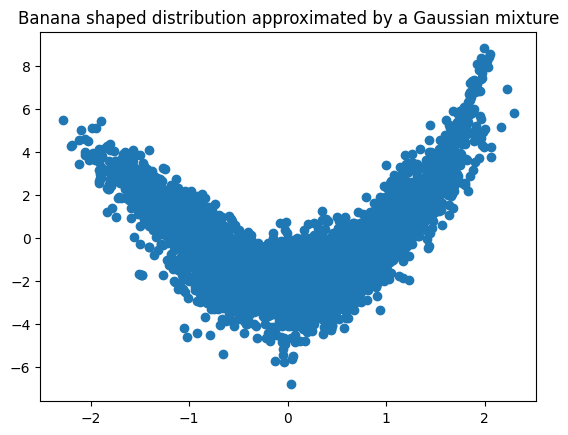

In [22]:
# Parameters 
sigma = 1 
b = 2.
d = 5
m = 5

# Apply the EM algorithm 
alpha, mu, sigma = ImportanceSampling(sigma, d, b, m, n_iter = 100)

X = sample_gaussian_mixture(5000, alpha, mu, sigma)[0]

plt.scatter(X[:, 0], X[:, 1])
plt.title("Banana shaped distribution approximated by a Gaussian mixture")
plt.show()